In [1]:
import jax
from jax import jit
import timeit
import jax.numpy as jnp
import numpy as np
from ott.geometry import pointcloud
from lower_bound import histogram_distances
import seaborn as sns
import matplotlib.pyplot as plt

from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.solvers.linear import sinkhorn
from ott.geometry.geometry import Geometry
import cProfile

In [2]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll

# Data parameters
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = jax.random.split(key, 4)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
N = 100
n_spiral = N
n_swiss_roll = N

spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)

In [4]:
def pairwise_dists(point_cloud : pointcloud, squared = False):
    norms = jnp.sum(jnp.square(point_cloud.x), axis = 1)
    dists_sq = jnp.maximum(norms[:, None] + norms[None, :] - 2 * point_cloud.x @ point_cloud.x.T, 0)
    if squared:
        return dists_sq
    else:
        return jnp.sqrt(dists_sq)

def one_d_wasserstein(u_values, v_values, u_weights = None, v_weights = None, p = 2):
    u_sorter = jnp.argsort(u_values)
    v_sorter = jnp.argsort(v_values)

    all_values = jnp.concatenate([u_values, v_values])
    # Perhaps the sort here can be converted to a softsort?
    # Also, the jax implementation of sort is quicksort.
    # This algorithm would be faster if it used mergesort instead.
    all_values_sorted = jnp.sort(all_values)

    # Compute the differences between pairs of successive values of u and v.
    deltas = jnp.diff(all_values_sorted)

    # Get the respective positions of the values of u and v among the values of
    # both distributions. 
    # I don't know of a way to make this part soft, though...
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values_sorted[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values_sorted[:-1], 'right')

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / u_values.size
    else:
        u_sorted_cumweights = jnp.concatenate((jnp.array([0]),
                                                jnp.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / v_values.size
    else:
        v_sorted_cumweights = jnp.concatenate((jnp.array([0]),
                                                jnp.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return jnp.sum(jnp.multiply(jnp.abs(u_cdf - v_cdf), deltas))
    elif p == 2:
        return jnp.sqrt(jnp.sum(jnp.multiply(jnp.square(u_cdf - v_cdf), deltas))) * np.sqrt(2)

def histogram_distances_from_vmap(pointcloud_x, pointcloud_y):
    dists_x = jnp.sort(pairwise_dists(pointcloud_x), axis = 1)
    dists_y = jnp.sort(pairwise_dists(pointcloud_y), axis = 1)

    vmap_one_d_wasserstein = jax.vmap(
        jax.vmap(
            one_d_wasserstein, 
            (None, 0), (0)), 
        (0, None), (0))

    return vmap_one_d_wasserstein(dists_x, dists_y)

In [5]:
histogram_distances_from_vmap_jit = jax.jit(histogram_distances_from_vmap)
histogram_distances_jit = jax.jit(histogram_distances)

# warm-up:
out_vmap = histogram_distances_from_vmap_jit(geom_xx, geom_yy)
out_norm = histogram_distances_jit(geom_xx, geom_yy)

In [6]:
%timeit histogram_distances_from_vmap_jit(geom_xx, geom_yy)

338 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit histogram_distances_jit(geom_xx, geom_yy)

221 ms ± 6.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def histogram_distances_v2(point_cloud_x : pointcloud, point_cloud_y : pointcloud, p = 1):
    """
    Computes the distances needed to compute the second lower bound from
    [Memoli 2011] in a vectorized and jitable format. The general strategy here is taken
    from the scipy function `scipy.stats._cdf_distance`.
    """
    dists_x = pairwise_dists(point_cloud_x)
    dists_y = pairwise_dists(point_cloud_y)

    N_x, N_y = dists_x.shape[0], dists_y.shape[0]
    # Sorting these first increases the speed of the later sorting!
    dists_x_sorted = jnp.sort(dists_x, axis = 1)
    dists_y_sorted = jnp.sort(dists_y, axis = 1)

    jax.vmap()

    return hist_dis_xy

In [24]:
distance_fn = jax.jit(lambda x, y: histogram_distances(x, y, p = 2))
distance_fn_opt = jax.jit(lambda x, y: histogram_distances_opt(x, y, p = 2))
solve_fn = jax.jit(sinkhorn.solve)

def lower_bound(geom_xx, geom_yy):
    xy_dist = distance_fn(geom_xx, geom_yy)
    geom_xy = Geometry(cost_matrix=xy_dist, epsilon = .05)
    ot = solve_fn(geom_xy)
    return ot

def lower_bound_opt(geom_xx, geom_yy):
    xy_dist = distance_fn_opt(geom_xx, geom_yy)
    geom_xy = Geometry(cost_matrix=xy_dist, epsilon = .05)
    ot = solve_fn(geom_xy)
    return ot


N = 100
n_spiral = N
n_swiss_roll = N

spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)

[Text(0.5, 1.0, 'Lower bound coupling')]

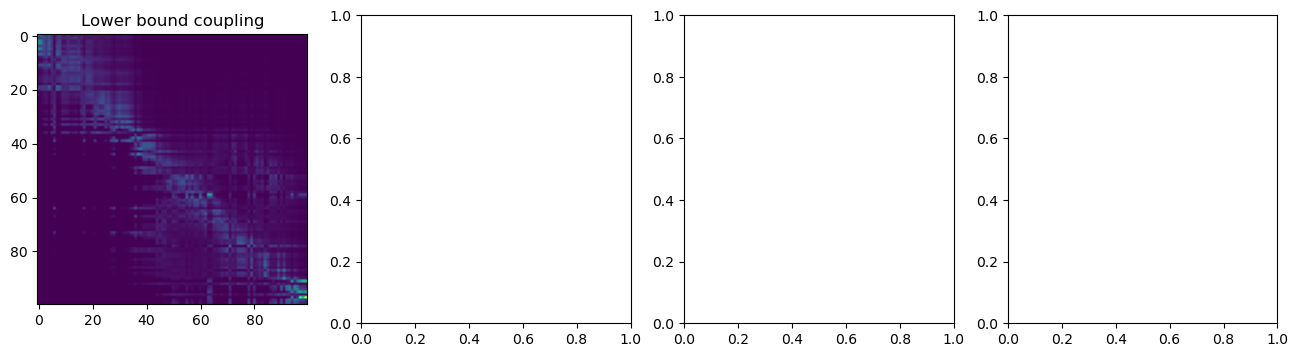

In [43]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))
out = lower_bound(geom_xx, geom_yy)
ax[0].imshow(out.matrix)
ax[0].set(title = "Lower bound coupling")

ax[0].imshow(out.matrix)
ax[0].set(title = "Lower bound coupling")
# lower_bound_opt(geom_xx, geom_yy)
# print('hi')

In [21]:
%timeit lower_bound_opt(geom_xx, geom_yy)
# %timeit lower_bound(geom_xx, geom_yy)

218 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
  # Run the operations to be profiled
  ot = lower_bound_opt(geom_xx, geom_yy)

2023-07-11 15:04:35.376956: E external/xla/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace
2023-07-11 15:04:35.657243: E external/xla/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace


Open URL in browser: https://ui.perfetto.dev/#!/?url=http://127.0.0.1:9001/perfetto_trace.json.gz


127.0.0.1 - - [11/Jul/2023 15:04:39] code 404, message File not found
127.0.0.1 - - [11/Jul/2023 15:04:39] "POST /status HTTP/1.1" 404 -
127.0.0.1 - - [11/Jul/2023 15:04:39] "GET /perfetto_trace.json.gz HTTP/1.1" 200 -
